In [1]:
import numpy as np
import pickle
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import xgboost as xgb
from datetime import datetime
from xgboost import XGBClassifier
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

In [2]:
def one_hot_encoder(x):

	encoded = np.zeros((len(x), 4))
	
	for idx, val in enumerate(x):
		encoded[idx][val-1] = 1
	
	return encoded

In [50]:
# Para Train
# Ruta de la carpeta que contiene las imágenes
carpeta_raiz_train = "C:\\Users\\halo4\\OneDrive\\Up\\Clases\\Aprenizaje maquina 2\\Proyecto\\Alzheimer_s Dataset\\train\\"  
list_train_carpetas = [carpeta_raiz_train + tipo for tipo in ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented']]

# Lista para almacenar las imágenes como arrays NumPy
imagenes_array_train = []
list_clases_train = []

In [51]:
for num,carpeta_imagenes in enumerate(list_train_carpetas):

    # Recorrer todas las imágenes en la carpeta
    for filename in os.listdir(carpeta_imagenes):
        if filename.endswith(".jpg"):  # Puedes ajustar la extensión según tus archivos
            ruta_imagen = os.path.join(carpeta_imagenes, filename)
            
            # Leer la imagen con PIL
            imagen_pil = Image.open(ruta_imagen).convert("RGB")
            
            # Convertir la imagen PIL a un array NumPy
            imagen_array = np.array(imagen_pil)
            
            # Añadir el array NumPy a la lista
            imagenes_array_train.append(imagen_array)
    
    
    list_clases_train += [num+1] * len(os.listdir(carpeta_imagenes))

In [52]:
# Convertir la lista de arrays NumPy a un array NumPy 4D
X_train = np.stack(imagenes_array_train)
y_train = np.stack(list_clases_train)

In [53]:
X_train.shape

(5121, 208, 176, 3)

In [9]:
y_train.shape

(5121,)

In [10]:
y_train = one_hot_encoder(y_train)

In [11]:
# Para TEST
# Ruta de la carpeta que contiene las imágenes
carpeta_raiz_train = "C:\\Users\\halo4\\OneDrive\\Up\\Clases\\Aprenizaje maquina 2\\Proyecto\\Alzheimer_s Dataset\\test\\"   
list_train_carpetas = [carpeta_raiz_train + tipo for tipo in ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented']]

# Lista para almacenar las imágenes como arrays NumPy
imagenes_array_test = []
list_clases_test = []

In [12]:
for num,carpeta_imagenes in enumerate(list_train_carpetas):

    # Recorrer todas las imágenes en la carpeta
    for filename in os.listdir(carpeta_imagenes):
        if filename.endswith(".jpg"):  # Puedes ajustar la extensión según tus archivos
            ruta_imagen = os.path.join(carpeta_imagenes, filename)
            
            # Leer la imagen con PIL
            imagen_pil = Image.open(ruta_imagen).convert("RGB")
            
            # Convertir la imagen PIL a un array NumPy
            imagen_array = np.array(imagen_pil)
            
            # Añadir el array NumPy a la lista
            imagenes_array_test.append(imagen_array)
    
    
    list_clases_test += [num+1] * len(os.listdir(carpeta_imagenes))

In [13]:
# Convertir la lista de arrays NumPy a un array NumPy 4D
X_test = np.stack(imagenes_array_test)
y_test = np.stack(list_clases_test)

In [14]:
y_test = one_hot_encoder(y_test)

In [15]:
# Entrenamiento Red Neuronal
NUM_CLASSES = 4
IMAGE_SIZE = [208,176]
EPOCHS = 50
BATCH_SIZE = 32

# Convertir los arrays NumPy en conjuntos de datos de TensorFlow
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [16]:
# Configurar el conjunto de datos de entrenamiento
train_ds = (
    train_ds
    .shuffle(buffer_size=len(X_train))
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [17]:
# Configurar el conjunto de datos de validación
val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [18]:
# Definicion de funciones para red neuronal
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.15.0


In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),

        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(128, 0.3),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [22]:
with strategy.scope():
    model = build_model()

    METRICS = ['accuracy', tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [23]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

In [24]:
exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=4,
                                                     restore_best_weights=True)

In [25]:
# Definición de stoptraining para red neuronal

class StopTrainingOnAUCDifference(Callback):
    def __init__(self, monitor_train='auc', monitor_val='val_auc', min_delta=0.04, patience=6, mode='max'):
        super(StopTrainingOnAUCDifference, self).__init__()
        self.monitor_train = monitor_train
        self.monitor_val = monitor_val
        self.min_delta = min_delta
        self.patience = patience
        self.mode = mode
        self.wait = 0
        self.stopped_epoch = 0

        if mode == 'min':
            self.min_delta *= -1
    def monitor_op(self, current_train, current_val, best_train, best_val):
        if self.mode == 'max':
            return (current_train - current_val) > self.min_delta 
        elif self.mode == 'min':
            return (current_train - current_val) > self.min_delta
        else:
            raise ValueError(f"Unsupported mode: {self.mode}")

    def on_epoch_end(self, epoch, logs=None):
        current_train_auc = logs.get(self.monitor_train)
        current_val_auc = logs.get(self.monitor_val)
        
        if current_train_auc is None or current_val_auc is None:
            raise ValueError(f"One or both metrics {self.monitor_train}, {self.monitor_val} are not available.")

        if epoch == 0:
            self.best_train_auc = current_train_auc
            self.best_val_auc = current_val_auc

        if self.monitor_op(current_train_auc, current_val_auc, self.best_train_auc, self.best_val_auc):
            self.best_train_auc = current_train_auc
            self.best_val_auc = current_val_auc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print(f"\nTraining stopped on epoch {epoch + 1} due to no improvement in AUC difference.")
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Training stopped on epoch {self.stopped_epoch + 1}.")


In [27]:
# Entrenar el modelo con el callback personalizado

history = model.fit(
    train_ds,
    validation_data=val_ds,    
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, lr_scheduler, StopTrainingOnAUCDifference()],
    epochs=EPOCHS
)

Epoch 1/50


161/161 [==============================] - ETA: 0s - loss: 1.1583 - accuracy: 0.4677 - auc: 0.7594

c:\Users\halo4\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


161/161 [==============================] - 35s 168ms/step - loss: 1.1583 - accuracy: 0.4677 - auc: 0.7594 - val_loss: 1.1497 - val_accuracy: 0.3370 - val_auc: 0.7184 - lr: 0.0100
Epoch 2/50
161/161 [==============================] - 25s 155ms/step - loss: 0.9551 - accuracy: 0.5464 - auc: 0.8256 - val_loss: 3.5604 - val_accuracy: 0.1384 - val_auc: 0.5144 - lr: 0.0089
Epoch 3/50
161/161 [==============================] - 37s 231ms/step - loss: 0.9157 - accuracy: 0.5638 - auc: 0.8397 - val_loss: 1.3556 - val_accuracy: 0.3526 - val_auc: 0.6190 - lr: 0.0079
Epoch 4/50
161/161 [==============================] - 39s 246ms/step - loss: 0.9021 - accuracy: 0.5725 - auc: 0.8435 - val_loss: 0.9885 - val_accuracy: 0.5528 - val_auc: 0.8370 - lr: 0.0071
Epoch 5/50
161/161 [==============================] - 39s 242ms/step - loss: 0.8816 - accuracy: 0.5874 - auc: 0.8507 - val_loss: 1.1962 - val_accuracy: 0.3479 - val_auc: 0.6543 - lr: 0.0063
Epoch 6/50
161/161 [==============================] - 39s 244

In [28]:
# Guardar modelo

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('C:\\Users\\halo4\\OneDrive\\Up\\Clases\\Aprenizaje maquina 2\\Proyecto\\Irving\\model_cnnv2.h5')

In [29]:
# Cargar el modelo

from tensorflow.keras.models import model_from_json

with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('C:\\Users\\halo4\\OneDrive\\Up\\Clases\\Aprenizaje maquina 2\\Proyecto\\Irving\\model_cnnv2.h5')

In [30]:
# Definir la funcion para obtener la última capa flatten

def get_feature_layer(model, data):
	
    total_layers = len(model.layers)

    fl_index = total_layers-4
	
    feature_layer_model = tf.keras.Model(
        inputs=model.input,
        outputs=model.get_layer(index=fl_index).output)
	
    feature_layer_output = feature_layer_model.predict(data)
	
    return feature_layer_output

In [31]:
# Definición de de función para entrenar modelo de xgboost

def xgb_model(X_train, y_train, X_test, y_test):
  
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)
  
  
    model = XGBClassifier(
        max_depth=20,
        learning_rate=0.05,
        n_estimators=100,
        objective='multi:softmax',  # Clasificación multiclase
        num_class=4,  # Número de clases en tu target
        eval_metric='mlogloss'  # Puedes ajustar la métrica según tus necesidades
    )
    model.fit(X_train, y_train)
    
    pickle.dump(model, open("cnn_xgboost_final.pickle.dat", "wb"))

    return model

In [56]:
# Entrenamineto de modelo Xgboost

X_train_cnn =  get_feature_layer(model,X_train)
print("Features extracted of training data")

X_test_cnn = get_feature_layer(model,X_test)
print("Features extracted of test data\n")

print("Build and save of CNN-XGBoost Model.")
model_x = xgb_model(X_train_cnn, y_train, X_test_cnn, y_test)

161/161 [==============================] - 9s 51ms/step
Features extracted of training data
40/40 [==============================] - 3s 54ms/step
Features extracted of test data

Build and save of CNN-XGBoost Model.


AxisError: axis 1 is out of bounds for array of dimension 1

In [33]:
# Colapsar matriz encoded de variable objetivo
y_train_encoded = np.argmax(y_train, axis=1)
y_test_encoded = np.argmax(y_test, axis=1)

In [34]:
# Comparacion de modelo CNN y CNN + XGboost
predictions_cnn = model.predict(X_test)
predictions_cnnxg = model_x.predict_proba(X_test_cnn)

40/40 [==============================] - 3s 54ms/step


In [35]:
y_test_raw = np.argmax(y_test, axis=1)
y_pred_raw = np.argmax(predictions_cnn, axis=1)

In [36]:
# Calcular la precisión
accuracy = accuracy_score(y_test_raw, y_pred_raw)

# Imprimir el resultado
print("Precisión cnn:", accuracy)

# Calcular la precisión
auc = roc_auc_score(y_test_raw, predictions_cnn, multi_class='ovr')

# Imprimir el resultado
print("AUC cnn:", auc)

Precisión cnn: 0.6606724003127443
AUC cnn: 0.8751086265814557


In [37]:
y_test_raw = np.argmax(y_test, axis=1)
y_pred_raw = np.argmax(predictions_cnnxg, axis=1)

In [38]:
# Calcular la precisión
accuracy = accuracy_score(y_test_raw, y_pred_raw)

# Imprimir el resultado
print("Precisión cnn + xgboost:", accuracy)

Precisión cnn + xgboost: 0.6637998436278343


In [39]:
# Calcular la precisión
auc = roc_auc_score(y_test_raw, predictions_cnnxg, multi_class='ovr')

# Imprimir el resultado
print("AUC cnn + xgboost:", auc)

AUC cnn + xgboost: 0.8243074172977117


In [40]:
predictions = loaded_model.predict(X_train)

predictions.shape
y_test.shape

161/161 [==============================] - 8s 48ms/step


(1279, 4)

In [41]:
y_test_raw = np.argmax(y_train, axis=1)
y_pred_raw = np.argmax(predictions, axis=1)

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [43]:
# Calcular la precisión
accuracy = accuracy_score(y_test_raw, y_pred_raw)

# Imprimir el resultado
print("Precisión:", accuracy)

# Calcular la precisión
auc = roc_auc_score(y_test_raw, predictions, multi_class='ovr')

# Imprimir el resultado
print("AUC:", auc)

Precisión: 0.9214997070884593
AUC: 0.9949118373291862


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [45]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_raw, y_pred_raw)

# Obtener las etiquetas únicas
class_labels = np.unique(np.concatenate((y_test_raw, y_pred_raw)))

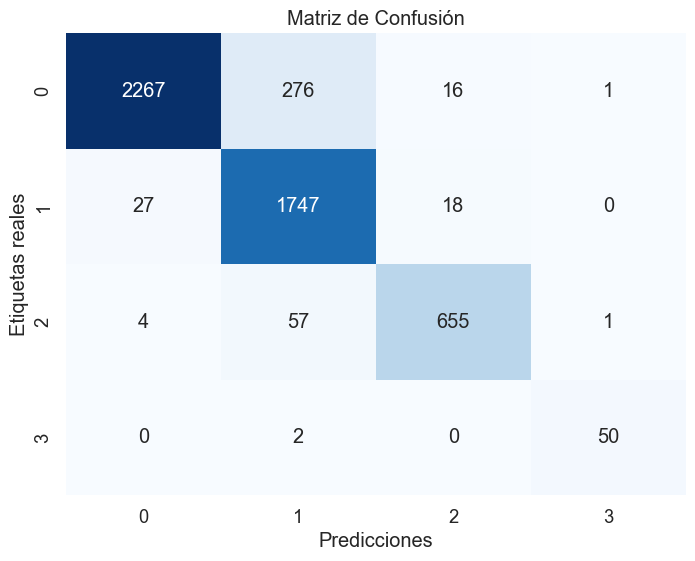

In [46]:
# Crear un mapa de calor con seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas reales')
plt.title('Matriz de Confusión')
plt.show()

In [47]:
from flask import Flask

In [ ]:
app = Flask(__name__)
# Python decorator: va a agregar mas cuncionalidad al modelo
@app.route("/")
def index():
    return "Hello world"
app.run(host = "0.0.0.0", port = 80)